This Notebook was created by Vincenzo Pluchino and Philip Tambè.

In [ ]:
#!pip install denoising_diffusion_pytorch datasets     #original code 
import sys  
import torch  

from google.colab import drive                        #mount the Drive into Colab
drive.mount("/content/drive/", force_remount=True)
cod_dir = "/content/drive/My Drive/results"

!git clone https://github.com/PhilipTamb/denoising_diffusion_pytorch_replication_result   #get our modified code from github
sys.path.append("/content/denoising_diffusion_pytorch_replication_result")                

Mounted at /content/drive/
Cloning into 'denoising_diffusion_pytorch_replication_result'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 147 (delta 53), reused 47 (delta 25), pack-reused 55
Receiving objects: 100% (147/147), 56.88 KiB | 14.22 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
#install dependencies
!pip install einops
!pip install ema_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the dataset from the huggingface hub
!pip install datasets
from datasets import load_dataset
cifar10 = load_dataset('cifar10')
cifar10['train'][0]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 31.8 MB/s 
     |████████████████████████████████| 140 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 212 kB 64.4 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
     |████████████████████████████████| 127 kB 78.4 MB/s 
     |████████████████████████████████| 144 kB 51.5 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 271 kB 51.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's de

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FE4C3B47550>,
 'label': 0}

In [ ]:
# Save the images to a folder for convenience
!mkdir -p train_images
def save_im(x, i):
  x['img'].save(f'train_images/{i:05}.png')
_ = cifar10['train'].map(save_im, with_indices=True)

Parameter 'function'=<function save_im at 0x7fe4c4132d40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/50000 [00:00<?, ?ex/s]

In [ ]:
torch.cuda.is_available()  #check if  GPU is available

True

In [ ]:
# create directorys for the results into GPU
!mkdir /content/results/
!mkdir /content/results/images
!mkdir /content/results/models
milestone = 0                   

In [ ]:
#copy the saving files into GPU directory
!cp /content/drive/MyDrive/results/*.pt /content/results/models

In [ ]:
# print saving model files
!ls /content/results/models

model-10.pt  model-16.pt  model-21.pt  model-27.pt  model-32.pt  model-7.pt
model-11.pt  model-17.pt  model-22.pt  model-28.pt  model-33.pt  model-8.pt
model-12.pt  model-18.pt  model-23.pt  model-29.pt  model-3.pt	 model-9.pt
model-13.pt  model-19.pt  model-24.pt  model-2.pt   model-4.pt
model-14.pt  model-1.pt   model-25.pt  model-30.pt  model-5.pt
model-15.pt  model-20.pt  model-26.pt  model-31.pt  model-6.pt


In [ ]:
# get list of models files
import glob
import os 

models_list = []
for filename in glob.glob("/content/results/models/*.pt"): 
    nomefile = os.path.basename(filename)
    models_list.append(nomefile)
print(models_list)

['model-19.pt', 'model-31.pt', 'model-8.pt', 'model-28.pt', 'model-25.pt', 'model-32.pt', 'model-3.pt', 'model-30.pt', 'model-15.pt', 'model-6.pt', 'model-27.pt', 'model-13.pt', 'model-18.pt', 'model-4.pt', 'model-16.pt', 'model-5.pt', 'model-7.pt', 'model-10.pt', 'model-29.pt', 'model-20.pt', 'model-9.pt', 'model-24.pt', 'model-17.pt', 'model-26.pt', 'model-12.pt', 'model-11.pt', 'model-1.pt', 'model-23.pt', 'model-21.pt', 'model-33.pt', 'model-22.pt', 'model-14.pt', 'model-2.pt']


In [ ]:
# sorting list and get the last model saved
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

models_list.sort(key=natural_keys)
number = re.findall(r'\d+', models_list[-1])
milestone = int(number[0])
print(milestone)

33


In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer  #import class

# Create the U-net model
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
).cuda()

In [ ]:
# Rough parameter count:
sum([p.numel() for p in model.parameters()]) # About the same as the 35 million in the paper

36255235

In [ ]:
# define parameters of Gaussian Diffusion Model
diffusion = GaussianDiffusion(
    model,                       # U-ned prior defined 
    image_size = 32,    
    timesteps = 1000,            # number of steps as in the paper
    beta_schedule = 'linear',    # TO follow paper
    loss_type = 'l2'             # l2 set the loss formula at MSE 
).cuda()

# specify the training parameters
trainer = Trainer(
    diffusion,                        # Gaussian Diffusion Model 
    'train_images',                   # Dataset directory prior created
    augment_horizontal_flip = True,   # Some augmentation as in paper since this is a small dataset
    train_batch_size = 128,           # following the size in the paper
    train_lr = 2e-4,                  # the same of the paper
    train_num_steps = 800000,         # number of steps in the paper, we never achive this steps with free Colab but we are optimistic! :)
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.9999,               # same EMA decay of the paper
    save_and_sample_every= 3000,      # timestep after which we save 20 images and 1 model parameter files
    results_folder= cod_dir,          # the saving folder linked in our drive
    ema_update_every= 10,             # updating the ema model every 10 steps to save compute
    amp = True                        # turn on mixed precision
)
if milestone != 0:                    # if there are saving models files, it load the last one model
 print("load model")
 trainer.load(milestone)
                                      # start training function
trainer.train()

load model


 12%|#1        | 93000/800000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# copying training ganerated imagies inside GPU directory
!cp /content/drive/MyDrive/results/*.png /content/results/images

In [ ]:
img_dir = '/content/results/images'
!ls /content/results/images

sample-0-12000.png   sample-15-3000.png   sample-3-42000.png
sample-0-15000.png   sample-15-33000.png  sample-3-45000.png
sample-0-18000.png   sample-15-36000.png  sample-3-48000.png
sample-0-21000.png   sample-15-39000.png  sample-3-51000.png
sample-0-24000.png   sample-1-54000.png   sample-3-54000.png
sample-0-27000.png   sample-15-42000.png  sample-3-57000.png
sample-0-30000.png   sample-15-45000.png  sample-3-60000.png
sample-0-3000.png    sample-15-48000.png  sample-3-6000.png
sample-0-33000.png   sample-15-51000.png  sample-3-63000.png
sample-0-36000.png   sample-15-54000.png  sample-3-66000.png
sample-0-39000.png   sample-15-57000.png  sample-3-69000.png
sample-0-42000.png   sample-15-60000.png  sample-3-72000.png
sample-0-45000.png   sample-15-6000.png   sample-3-75000.png
sample-0-48000.png   sample-15-63000.png  sample-3-78000.png
sample-0-51000.png   sample-15-66000.png  sample-3-81000.png
sample-0-54000.png   sample-15-69000.png  sample-3-84000.png
sample-0-57000.png   samp

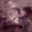

In [ ]:
from PIL import Image
Image.open(img_dir + '/sample-0-6000.png') 

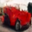

In [ ]:
Image.open(img_dir +'/sample-0-30000.png') 

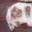

In [ ]:
Image.open(img_dir +'/sample-0-54000.png')

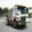

In [ ]:
Image.open(img_dir +'/sample-0-75000.png')

In [ ]:
# compute the FID metric
!pip install Pillow==9.0.0
!pip install clean-fid
from cleanfid import fid

fdir2 = img_dir            # images folder
fid_score = fid.compute_fid(fdir2, dataset_name="cifar10", dataset_res=32, dataset_split="train")   # we set CIFAR10 dataset to compute the FID
print(fid_score)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 33.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 9.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


downloading statistics to /usr/local/lib/python3.7/dist-packages/cleanfid/stats/cifar10_clean_train_32.npz


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found 660 images in the folder /content/results/images


FID images : 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


75.29177639109844


In [ ]:
# import code for compute Inception Score
!git clone https://github.com/kvpratama/gan_metrics.git

Cloning into 'gan_metrics'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 6), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
# delete model directory because create problems to compute Inception Score
import shutil
shutil.rmtree('/content/results/models')

In [ ]:
!ls /content/results/models        #the directory must be inexistent

ls: cannot access '/content/results/models': No such file or directory


In [ ]:
# Compute and print Iception Score
!python /content/gan_metrics/inception_score.py --dataroot "/content/results/"

Calculating Inception Score...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100% 104M/104M [00:02<00:00, 53.8MB/s]
21 / 21
Computing KL-Div Mean...
10 / 10
(4.711903062440186, 0.44403124372331315)
